# Обучение с помощью датасета

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install gymnasium[mujoco]
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3
    !pip -q install gymnasium_robotics
    !pip -q install h5py

In [ ]:
if COLAB:
    !wget -O "data_umaze_bad.hdf5" --no-check-certificate "https://drive.usercontent.google.com/download?id=1t_aAlPjniYUYL63CryEmhEJUyWkQBdCB&export=download&authuser=0"
    !wget -O "data_umaze_dense.hdf5" --no-check-certificate "https://drive.usercontent.google.com/download?id=1hw5pbbyPUcffmVKM1FMdaDR93nEuqqsu&export=download&authuser=0"

In [ ]:
# Проверка, что датасет открывается
import h5py
file_name = '/content/data_umaze_dense.hdf5'
file_name = '/content/data_umaze_bad.hdf5'
data = dict()
with h5py.File(file_name, "r") as f:
    for key in f.keys():
        if key == "infos":
            for info_key in f[key].keys():
                data[info_key] = f.get(key)[info_key][:]
            continue
        data[key] = f.get(key)[:]

print(data.keys())
data['observations'].shape[0]

In [ ]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

from dataclasses import dataclass

import os
import random
import time
import h5py

import numpy as np
import gymnasium as gym
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

TensorBatch = List[torch.Tensor]

try:
    import wandb
    WANDB_IS_AVAILABLE = True
except ImportError:
    WANDB_IS_AVAILABLE = False

# your_wandb_api_key = "your wandb-api key"
####### Здесь ваш код ########
raise NotImplementedError
##############################
os.environ["WANDB_API_KEY"] = your_wandb_api_key

## Среда PointMaze

Среда для экспериментов: [**PointMaze**](https://robotics.farama.org/envs/maze/point_maze/).

Задача поиска пути в лабиринте:
- расположение препятствия фиксированное
- начальная точка и точка цели задается в заранее определенной области
- агент достиг своей цели, если расстояние между ним и целью < 0.5
- конец эпизода: агент достиг своей цели или превышено число допустимых шагов в среде
- награда: 1, если агент достиг цели
- наблюдения: координаты агента, скорость агента, координаты цели $$obs = [x_a, y_a, v_x, v_y, x_g, y_g]$$
- действие: линейная сила $$action = [F_x, F_y]$$
- метрика: $SR = \frac{success}{n_{ep}}$ -- процент успешно завершенных эпизодов. Агент решает задачу поиска пути от начальной точки до точки цели $n_{ep}$ раз. $success$ -- сколько раз цель была достигнута.


In [ ]:
import gymnasium_robotics

gym.register_envs(gymnasium_robotics)


class PointMazeArrayObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Формируется векторное наблюдение
        self._obs_keys = ["observation", "desired_goal"]
        new_obs_len = np.sum(
            [self.observation_space[k].shape[0] for k in self._obs_keys]
        )
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(new_obs_len,), dtype=np.float32
        )

    def observation(self, obs):
        array_obs = np.concatenate([obs[key].flatten() for key in self._obs_keys])
        return array_obs


In [ ]:
def make_env(seed):
    def thunk():
        # 'r' -- возможная начальная точка для агента, 'g' -- возможная целевая точка,
        # 'c' -- начальная или целевая точка
        map_ = [
            [1, 1, 1, 1, 1],
            [1, 0, "r", 0, 1],
            [1, 1, 1, 0, 1],
            [1, 0, "g", 0, 1],
            [1, 1, 1, 1, 1],
        ]
        env = gym.make(
            "PointMaze_UMaze-v3",
            max_episode_steps=200,
            maze_map=map_,
            continuing_task=False,
        )
        env = PointMazeArrayObservationWrapper(env)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

Отрисовка траекторий

In [ ]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_walls(walls):
    (height, width) = walls.shape
    for i, j in zip(*np.where(walls)):
        x = np.array([j, j + 1]) -width/2
        y0 = np.array([i, i]) -height/2
        y1 = np.array([i + 1, i + 1]) -height/2
        plt.fill_between(x, y0, y1, color="grey")
    plt.xticks([])
    plt.yticks([])

def plot_all_trajectories( walls=None, trajectories_=None, traj_filepath='output.png'):
    plt.clf()
    if walls  is not None:
        plot_walls(walls)
    if trajectories_ is not None:
        all_points = trajectories_
        sns.kdeplot(x=all_points[:, 0], y=all_points[:, 1], cmap='viridis', fill=True, alpha=0.5)
    plt.savefig(traj_filepath)

def plot_start_and_end_points(points, traj_filepath="start_and_end.png"):
    plt.clf()
    plt.scatter(
        points[:, 0],
        points[:, 1],
        marker=".",
        color="red",
        s=200,
        label="start",
    )
    plt.scatter(
        points[:, 2],
        points[:, 3],
        marker=".",
        color="green",
        s=200,
        label="end",
    )
    plt.savefig(traj_filepath)


def plot_one_trajectory(obs_vec, goal=None, walls=None, traj_filepath='output.png'):
    plt.clf()
    if walls  is not None:
        plot_walls(walls)

    if (obs_vec is not None):
        obs_vec = np.array(obs_vec)
        plt.plot(obs_vec[:, 0], obs_vec[:, 1], ".", alpha=0.3)
        plt.scatter(
            [obs_vec[0, 0]],
            [obs_vec[0, 1]],
            marker="+",
            color="red",
            s=200,
            label="start",
        )
        plt.scatter(
            [obs_vec[-1, 0]],
            [obs_vec[-1, 1]],
            marker="+",
            color="green",
            s=200,
            label="end",
        )
        if (goal is not None):
            plt.scatter(
                goal[:,0], goal[:,1], marker="*", color="green", s=200, label="goal"
            )
    plt.savefig(traj_filepath)


Тестирование агента

In [ ]:
@dataclass
class EnvConfig:
    num_eval_episodes: int = 10
    eval_seed: int = 10

In [ ]:
# Стратегия для случайного агента
class RandomAgent(nn.Module):
    def __init__(self, action_space):
        super().__init__()
        self.action_space = action_space

    def get_action(self, observation: np.ndarray, epsilon: float = 0.0) -> int:
        actions = self.action_space.sample()
        return actions

In [ ]:
class Evaluate:
    def __init__(self, make_env, config):
        self.num_episodes = config.num_eval_episodes
        self.seed = config.eval_seed
        self.env = make_env(self.seed)()
        self.map_ = [
            [1, 1, 1, 1, 1],
            [1, 0, 0, 0, 1],
            [1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1],
            [1, 1, 1, 1, 1],
        ]
        self.map_ = np.array(self.map_)

    def eval_actor(self, actor):
        actor.eval()
        success = []
        for _ in range(self.num_episodes):
            state, info = self.env.reset()
            done, tr = False, False
            while not (done or tr):
                action = actor.get_action(state)
                state, reward, done, tr, info = self.env.step(action)
            if "success" in info:
                success.append(info["success"])
            else:
                success.append(info["episode"]["r"])

        actor.train()
        return np.asarray(success).mean()

    def eval_tr(self, actor, num_episodes=1, traj_filepath='output.png'):
        actor.eval()
        success = []
        observations = []
        for _ in range(num_episodes):
            state, info = self.env.reset()
            observations.append(state)
            done, tr = False, False
            while not (done or tr):
                action = actor.get_action(state)
                state, reward, done, tr, info = self.env.step(action)
                observations.append(state)
            if "success" in info:
                success.append(info["success"])
            else:
                success.append(info["episode"]["r"])

        actor.train()
        print(f"SR: {np.asarray(success).mean()}")
        plot_one_trajectory(observations, traj_filepath=traj_filepath, walls = self.map_)

In [ ]:
eval = Evaluate(make_env, EnvConfig())
eval.eval_tr(RandomAgent(eval.env.action_space))

In [ ]:
from IPython.display import Image

Image(filename='output.png')

## Методы (основная информация)

Обозначения:
- $s$ - состояние, $r$ - вознаграждение, $a$ - действие, $s'$ - следующее состояние
- Условное распределение действий $\pi(a | s)$ - стратегия агента
- $\tau$ - траектория: $(s_0, r_0, a_0), \dots, (s_T, r_T, a_T)$
- Отдача $G(\tau) = \sum_{t = 0} ^ T r_t \gamma ^ t$
- $G_t = r_t + r_{t + 1} \gamma + \dots + r_{T} \gamma ^ {T - t}$
- Функция полезности состояний: $V(s_{t}) = \mathbb{E}[G_t]$
- Функция полезности действий: $Q(s_t, a_t) = \mathbb{E}[r_t + \gamma V(s_{t + 1}) | a_t]$

**Датасет** $\mathcal{D} = \{ (s, a, r, s')\}$ собран с помощью неизвестной **экспертной стратегии** $\pi_\beta$. $s \sim d^\pi$ -- множество состояний в памяти.

Цель: $\max_\pi \sum\limits_{t=0}^T \mathbb{E}_{s_t \sim d^\pi, a_t \sim \pi(a | s)} \left[\gamma^t r(s_t, a_t)\right]$


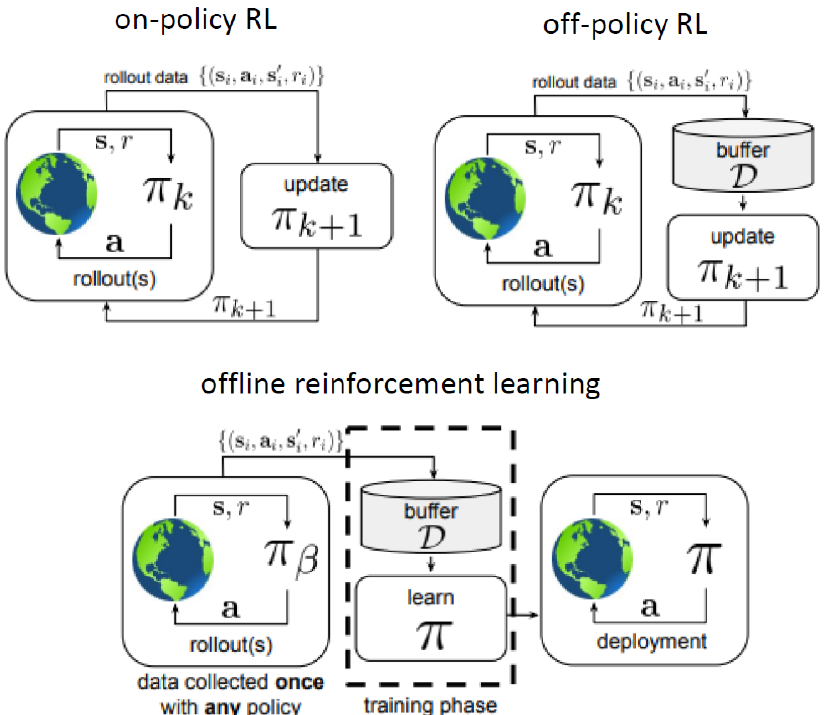



Хороший датасет (см. рис., траектории в датасете проходят по синей области):
- агент-эксперт обучен с помощью SAC  (задание, где начальная и целевая точки могут быть в любом месте на карте).

Плохой датасет:
- агент-эксперт способен найти путь до цели, но для этого ему требуется большее число шагов, чем в первом варианте.


<div>
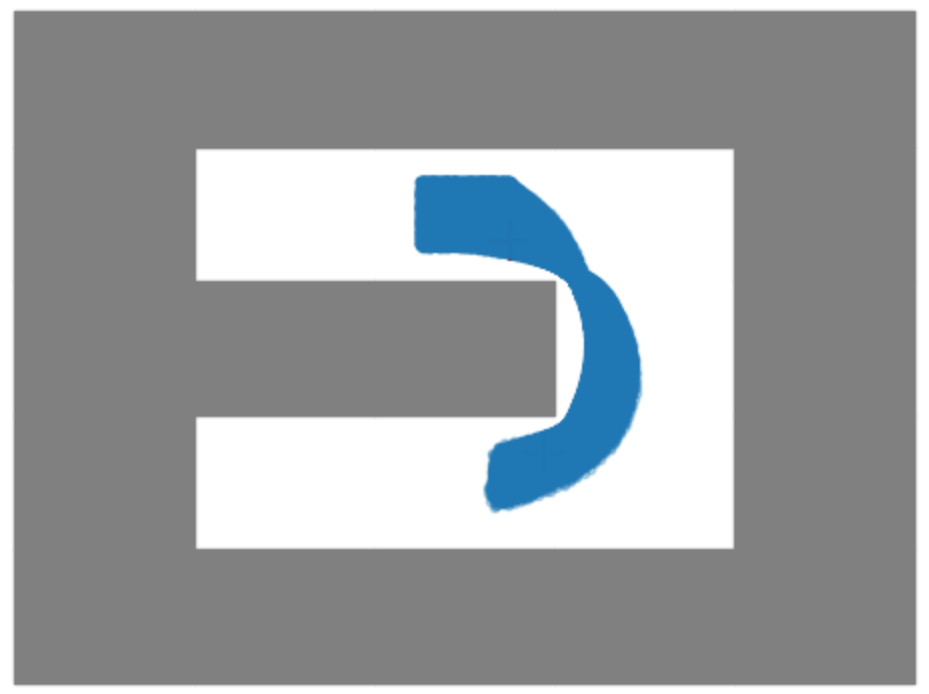
</div>

Как скачать датасет отдельно:


In [ ]:
# Проверка, что датасет открывается
import h5py
file_name = '/content/data_umaze_dense.hdf5'
data = dict()
with h5py.File(file_name, "r") as f:
    for key in f.keys():
        if key == "infos":
            for info_key in f[key].keys():
                data[info_key] = f.get(key)[info_key][:]
            continue
        data[key] = f.get(key)[:]

Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        buffer_size: int,
        device: str = "cpu",
        config=None,
    ):
        self._buffer_size = buffer_size
        self._pointer = 0
        self._size = 0
        self._config = config

        self._states = torch.zeros(
            (buffer_size, state_dim), dtype=torch.float32, device=device
        )
        self._actions = torch.zeros(
            (buffer_size, action_dim), dtype=torch.float32, device=device
        )
        self._rewards = torch.zeros(
            (buffer_size, 1), dtype=torch.float32, device=device
        )
        self._next_states = torch.zeros(
            (buffer_size, state_dim), dtype=torch.float32, device=device
        )
        self._dones = torch.zeros((buffer_size, 1), dtype=torch.float32, device=device)
        self._device = device

    def _to_tensor(self, data: np.ndarray) -> torch.Tensor:
        return torch.tensor(data, dtype=torch.float32, device=self._device)

    def load_dataset_from_file(self, path: str, with_goal: bool):
        data = dict()
        with h5py.File(path, "r") as f:
            for key in f.keys():
                if key == "infos":
                    for info_key in f[key].keys():
                        data[info_key] = f.get(key)[info_key][:]
                    continue
                data[key] = f.get(key)[:]
        return data

    def load_dataset(self, data: Dict[str, np.ndarray]):
        # Для offline методов: загрузка датасета
        if self._size != 0:
            raise ValueError("Trying to load data into non-empty replay buffer")
        n_transitions = data["observations"].shape[0]
        if n_transitions > self._buffer_size:
            raise ValueError(
                "Replay buffer is smaller than the dataset you are trying to load!"
            )
        self._states[:n_transitions] = self._to_tensor(data["observations"])
        self._actions[:n_transitions] = self._to_tensor(data["actions"])
        self._rewards[:n_transitions] = self._to_tensor(data["rewards"][..., None])
        self._next_states[:n_transitions] = self._to_tensor(data["next_observations"])
        self._dones[:n_transitions] = self._to_tensor(data["terminals"][..., None])
        self._size += n_transitions
        self._pointer = min(self._size, n_transitions)

        print(f"Dataset size: {n_transitions}")

    def sample(self, batch_size: int) -> TensorBatch:
        indices = np.random.randint(0, self._size, size=batch_size)
        states = self._states[indices]
        actions = self._actions[indices]
        rewards = self._rewards[indices]
        next_states = self._next_states[indices]
        dones = self._dones[indices]
        return [states, actions, rewards, next_states, dones]

    def add_transition(
        self,
        state: np.ndarray,
        action: np.ndarray,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ):
        # Для off-policy методов: добавление данных при взаимодействии агента со средой
        self._states[self._pointer] = self._to_tensor(state)
        self._actions[self._pointer] = self._to_tensor(action)
        self._rewards[self._pointer] = self._to_tensor(reward)
        self._next_states[self._pointer] = self._to_tensor(next_state)
        self._dones[self._pointer] = self._to_tensor(done)

        self._pointer = (self._pointer + 1) % self._buffer_size
        self._size = min(self._size + 1, self._buffer_size)


Логирование

In [ ]:
class Logger:
    def __init__(self, args):
        run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
        if args.track:
            import wandb

            self.run = wandb.init(
                project=args.wandb_project_name,
                entity=args.wandb_entity,
                sync_tensorboard=True,
                config=vars(args),
                name=run_name,
                monitor_gym=True,
                save_code=True,
            )
        else:
            self.run = None
        self.writer = SummaryWriter(f"runs/{run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s"
            % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
        )

    def init_time(self):
        self.start_time = time.time()

    def log_metric(self, metric_dict: dict, global_step: int):
        for key, item in metric_dict.items():
            self.writer.add_scalar(key, item, global_step)

    def time_step(self, global_step):
        if global_step % 100 == 0:
            print("SPS:", int(global_step / (time.time() - self.start_time)))
            self.log_metric(
                {"charts/SPS": int(global_step / (time.time() - self.start_time))},
                global_step,
            )

    def close(self):
        self.writer.close()
        if self.run:
            self.run.finish()


Цикл обучения

In [ ]:
def train_offpolicy(env, agent, rb, config, logger, eval_):
    if config.checkpoints_path is not None:
        print(f"Checkpoints path: {config.checkpoints_path}")
        os.makedirs(config.checkpoints_path, exist_ok=True)

    # start train
    obs, _ = env.reset(seed=config.seed)
    for global_step in range(config.total_timesteps):
        # выбор действий
        if global_step < config.learning_starts:
            actions = np.array(env.action_space.sample())
        else:
            actions = agent.get_action(obs)

        # выполнение действия в среде
        next_obs, rewards, terminations, truncations, infos = env.step(actions)

        # логирование информации
        if terminations or truncations:
            if (infos is not None) and ("episode" in infos):
                print(
                    f"global_step={global_step}, episodic_return={infos['episode']['r']}"
                )
                metrics = {
                    "charts/episodic_return": infos["episode"]["r"],
                    "charts/episodic_length": infos["episode"]["l"],
                }
                if "success" in infos:
                    metrics["charts/success"] = infos["success"]
                logger.log_metric(metrics, global_step)

        # сохранение данных в ReplayBuffer
        real_next_obs = next_obs.copy()
        rb.add_transition(obs, actions, rewards, real_next_obs, terminations)

        if terminations or truncations:
            next_obs, _ = env.reset()
        obs = next_obs

        # обучение
        if global_step > config.learning_starts:
            data = rb.sample(config.batch_size)
            metrics = agent.update(data, global_step)

            # логгирование
            if global_step % config.eval_freq == 0:
                SR = eval_.eval_actor(agent)
                metrics["SR"] = SR
                logger.log_metric(metrics, global_step)
                logger.time_step(global_step)
                print(f"Step {global_step}: SR = {SR}")
                if config.checkpoints_path:
                    torch.save(
                        agent.state_dict(),
                        os.path.join(
                            config.checkpoints_path, f"checkpoint_{global_step}.pt"
                        ),
                    )


def train_offline(env, agent, rb, config, logger, eval_):
    if config.checkpoints_path is not None:
        print(f"Checkpoints path: {config.checkpoints_path}")
        os.makedirs(config.checkpoints_path, exist_ok=True)
    # данные загружаются в ReplayBuffer
    dataset = rb.load_dataset_from_file(path=config.data_path, with_goal=False)
    rb.load_dataset(dataset)

    # start train
    obs, _ = env.reset(seed=config.seed)
    for global_step in range(config.total_timesteps):
        # обучение
        data = rb.sample(config.batch_size)
        metrics = agent.update(data, global_step)

        # логгирование
        if global_step % config.eval_freq == 0:
            SR = eval_.eval_actor(agent)
            metrics["SR"] = SR
            logger.log_metric(metrics, global_step)
            logger.time_step(global_step)
            print(f"Step {global_step}: SR = {SR}")
            if config.checkpoints_path:
                torch.save(
                    agent.state_dict(),
                    os.path.join(
                        config.checkpoints_path, f"checkpoint_{global_step}.pt"
                    ),
                )


def train(config, Agent, ReplayBuffer, train_func, make_env):
    logger = Logger(config)

    # seeding
    random.seed(config.seed)
    np.random.seed(config.seed)
    torch.manual_seed(config.seed)
    torch.backends.cudnn.deterministic = config.torch_deterministic

    device = torch.device(
        "cuda" if torch.cuda.is_available() and config.cuda else "cpu"
    )

    # среда
    env = make_env(config.seed)()
    eval_ = Evaluate(make_env, config)

    observation_space_shape = env.observation_space.shape
    action_space = env.action_space
    env.observation_space.dtype = np.float32

    # агент
    agent = Agent(config, device, observation_space_shape, action_space)

    rb = ReplayBuffer(
        buffer_size=config.buffer_size,
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.shape[0],
        device=device,
        config=config,
    )

    logger.init_time()

    # обучение
    train_func(env, agent, rb, config, logger, eval_)

    env.close()
    logger.close()
    return agent

Общая конфигурация для экспериментов

In [ ]:
@dataclass
class ConfigExp:
    exp_name: str = "offline_rl"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = True
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "offline-rl-hw"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    env_id: str = "PointMaze_UMaze-v3"
    """the environment id of the task"""
    total_timesteps: int = 300000
    """total timesteps of the experiments"""
    num_envs: int = 1
    """the number of parallel game environments"""
    buffer_size: int = int(1e6)
    """the replay memory buffer size"""

    eval_freq: int = int(5e3)
    checkpoints_path: str = "model"
    eval_seed: int = 1024
    num_eval_episodes: int = 10

In [ ]:

LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor(nn.Module):
    def __init__(self, observation_space_shape, action_space):
        super().__init__()
        self.fc1 = nn.Linear(np.array(observation_space_shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (action_space.high - action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (action_space.high + action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (
            log_std + 1
        )  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum()
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

class SoftQNetwork(nn.Module):
    def __init__(self, observation_space_shape, action_space):
        super().__init__()
        self.fc1 = nn.Linear(
            np.array(observation_space_shape).prod() + np.prod(action_space.shape),
            256,
        )
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

EXP_ADV_MAX = 100.0


class Squeeze(nn.Module):
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.squeeze(dim=self.dim)


class MLP(nn.Module):
    def __init__(
        self,
        dims,
        activation_fn: Callable[[], nn.Module] = nn.ReLU,
        output_activation_fn: Callable[[], nn.Module] = None,
        squeeze_output: bool = False,
        dropout: Optional[float] = None,
    ):
        super().__init__()
        n_dims = len(dims)
        if n_dims < 2:
            raise ValueError("MLP requires at least two dims (input and output)")

        layers = []
        for i in range(n_dims - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(activation_fn())

            if dropout is not None:
                layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(dims[-2], dims[-1]))
        if output_activation_fn is not None:
            layers.append(output_activation_fn())
        if squeeze_output:
            if dims[-1] != 1:
                raise ValueError("Last dim must be 1 when squeezing")
            layers.append(Squeeze(-1))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ValueFunction(nn.Module):
    def __init__(self, state_dim: int, hidden_dim: int = 256, n_hidden: int = 2):
        super().__init__()
        dims = [state_dim, *([hidden_dim] * n_hidden), 1]
        self.v = MLP(dims, squeeze_output=True)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.v(state)

# Базовые методы

## Behavioral Cloning

Копирование поведения (обучение с учителем)
- собран датасет $\mathcal{D} = \{ (s_i, a_i)\}_{i = 0}^N$,
- модель $\mathcal{A}$ для состояния $s$ предсказывает действие $a$: $a = \mathcal{A}(s)$.

Проблемы:
- со временем копится ошибка,
- распределение состояний в обучающей выборке и в тестовой сильно различается.

Простой способ улучшить метод: фильтрация данных

Конфигурация

In [ ]:
@dataclass
class ConfigBC(ConfigExp):
    batch_size: int = 1024
    policy_lr: float = 3e-4
    data_path: str = "/content/data_umaze_dense.hdf5"

(1 балл)

In [ ]:
# data =
        #           obs: torch.Tensor,
        #           action: torch.Tensor,
        #           reward: torch.Tensor,
        #           next_obs: torch.Tensor,
        #           done: torch.Tensor,

class BCAgent(nn.Module):
    def __init__(self, cfg: ConfigBC, device, observation_space_shape, action_space):
        super().__init__()
        self.cfg = cfg
        self.device = device
        self.init_actor(observation_space_shape, action_space)

    def init_actor(self, observation_space_shape, action_space):
        self.actor = Actor(observation_space_shape, action_space).to(self.device)
        self.actor_optimizer = optim.Adam(
            list(self.actor.parameters()), lr=self.cfg.policy_lr
        )

    def update(
        self,
        data,
        global_step,
    ) -> dict:
        # update actor
        observations = data[0]
        action = data[1]

        pi, log_pi, _ = self.actor.get_action(observations)

        # TODO: actor_loss = ...
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        actor_metrics = {"losses/actor_loss": actor_loss.item()}
        return actor_metrics

    def get_action(self, observation: np.ndarray, epsilon: float = 0.0) -> int:
        actions, _, _ = self.actor.get_action(torch.Tensor(observation).to(self.device))
        actions = actions.detach().cpu().numpy()
        return actions

    def state_dict(self) -> Dict[str, Any]:
        return {
            "actor": self.actor.state_dict(),
            "actor_optim": self.actor_optimizer.state_dict(),
        }

    def load_state_dict(self, state_dict: Dict[str, Any]):
        self.actor.load_state_dict(state_dict=state_dict["actor"])
        self.actor_optimizer.load_state_dict(state_dict=state_dict["actor_optim"])


### Хороший датасет


In [ ]:
config = ConfigBC(data_path="/content/data_umaze_dense.hdf5",
                  total_timesteps=1000, eval_freq= int(1e2))
agent_BC = train(config, BCAgent, ReplayBuffer, train_offline, make_env)

In [ ]:
eval = Evaluate(make_env, EnvConfig())
eval.eval_tr(agent_BC)
Image(filename='output.png')

### Плохой датасет

In [ ]:
config = ConfigBC(data_path="/content/data_umaze_bad.hdf5",
                  total_timesteps=1000, eval_freq= int(1e2))
agent_BC = train(config, BCAgent, ReplayBuffer, train_offline, make_env)

In [ ]:
eval = Evaluate(make_env, EnvConfig())
eval.eval_tr(agent_BC)
Image(filename='output.png')

## Soft Actor-Critic

Материалы: лекция 7

Основные особенности SAC:
1. Off-policy (обучение по отложенному опыту).
2. Одновременно обновляется стратегия $\pi_\theta$ и две Q-функции $Q_1$ и $Q_2$.
$$Q'(s, a) = \min\left(Q_1(s, a), Q_2(s, a)\right)$$
3. Добавление энтропии $$H(P) = \mathbb{E}_{x \sim P} \left[ -\log P(x) \right]$$
$$Q(s, a) = \min\left(Q_1(s, a), Q_2(s, a)\right) - \alpha \log \pi(a | s) $$
4. Уравнение Беллмана:
$$Q(s, a) = \mathbb{E}_{s' \sim P, a' \sim \pi}  \left[ r(s, a, s') + \gamma (Q'(s', a') + \alpha  H(\pi(\dot{\;} | s)))\right].$$
5. Параметр $\alpha$ может быть фиксированным или обучаемым.




In [ ]:
@dataclass
class ConfigSAC(ConfigExp):
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 0.005
    """target smoothing coefficient (default: 0.005)"""
    batch_size: int = 1024
    """the batch size of sample from the reply memory"""
    learning_starts: int = 5e3
    """timestep to start learning"""
    policy_lr: float = 3e-4
    """the learning rate of the policy network optimizer"""
    q_lr: float = 1e-3
    """the learning rate of the Q network network optimizer"""
    policy_frequency: int = 2
    """the frequency of training policy (delayed)"""
    target_network_frequency: int = 1  # Denis Yarats' implementation delays this by 2.
    """the frequency of updates for the target nerworks"""
    alpha: float = 0.2
    """Entropy regularization coefficient."""
    autotune: bool = True
    """automatic tuning of the entropy coefficient"""

    data_path: str = "notebook/data_umaze_d.hdf5"


(3 балла)

In [ ]:
class SACAgent(nn.Module):
    def __init__(self, cfg: ConfigSAC, device, observation_space_shape, action_space):
        super().__init__()
        self.cfg = cfg
        self.device = device
        self.init_actor_critic(observation_space_shape, action_space)

    def init_actor_critic(self, observation_space_shape, action_space):
        self.actor = Actor(observation_space_shape, action_space).to(self.device)
        self.qf1 = SoftQNetwork(observation_space_shape, action_space).to(self.device)
        self.qf2 = SoftQNetwork(observation_space_shape, action_space).to(self.device)
        self.qf1_target = SoftQNetwork(observation_space_shape, action_space).to(
            self.device
        )
        self.qf2_target = SoftQNetwork(observation_space_shape, action_space).to(
            self.device
        )
        self.qf1_target.load_state_dict(self.qf1.state_dict())
        self.qf2_target.load_state_dict(self.qf2.state_dict())
        self.q_optimizer = optim.Adam(
            list(self.qf1.parameters()) + list(self.qf2.parameters()), lr=self.cfg.q_lr
        )
        self.actor_optimizer = optim.Adam(
            list(self.actor.parameters()), lr=self.cfg.policy_lr
        )

        # Automatic entropy tuning
        if self.cfg.autotune:
            self.target_entropy = -torch.prod(
                torch.Tensor(action_space.shape).to(self.device)
            ).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha = self.log_alpha.exp().item()
            self.a_optimizer = optim.Adam([self.log_alpha], lr=self.cfg.q_lr)
        else:
            self.alpha = self.cfg.alpha

    def actor_loss(self, pi, log_pi, data):
        observations = data[0]
        # actor_loss = mean(- (Q' + a H))
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        return actor_loss

    def compute_critic_loss(
        self,
        data,
    ) -> Tuple[torch.Tensor, dict, dict]:
        observations, actions, rewards, next_observations, dones = data
        rewards = rewards.flatten()
        dones = dones.flatten()
        with torch.no_grad():
            next_state_actions, next_state_log_pi, _ = self.actor.get_action(
                next_observations
            )
            # TODO: для s', a' вычислить Q(s', a') с помощью уравнения Беллмана
            #         1) min_qf_next_target = Q' + a H
            #         2) next_q_value = Q(s', a') = r + (1 - d) * gamma * min_qf_next_target
            ####### Здесь ваш код ########
            raise NotImplementedError
            ##############################

        qf1_a_values = self.qf1(observations, actions).view(-1)
        qf2_a_values = self.qf2(observations, actions).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)
        qf2_loss = F.mse_loss(qf2_a_values, next_q_value)
        qf_loss = qf1_loss + qf2_loss
        metrics = {
            "losses/qf1_values": qf1_a_values.mean().item(),
            "losses/qf2_values": qf2_a_values.mean().item(),
            "losses/qf1_loss": qf1_loss.item(),
            "losses/qf2_loss": qf2_loss.item(),
            "losses/qf_loss": qf_loss.item() / 2.0,
        }
        return qf_loss, metrics

    def update_critic(
        self,
        data,
    ) -> dict:
        qf_loss, metrics = self.compute_critic_loss(data)

        # optimize the model
        self.q_optimizer.zero_grad()
        qf_loss.backward()
        self.q_optimizer.step()

        return metrics

    def update_target_critic(self):
        for param, target_param in zip(
            self.qf1.parameters(), self.qf1_target.parameters()
        ):
            target_param.data.copy_(
                self.cfg.tau * param.data + (1 - self.cfg.tau) * target_param.data
            )
        for param, target_param in zip(
            self.qf2.parameters(), self.qf2_target.parameters()
        ):
            target_param.data.copy_(
                self.cfg.tau * param.data + (1 - self.cfg.tau) * target_param.data
            )

    def update_alpha_loss(self, data):
        observations = data[0]
        metrics = dict()
        if self.cfg.autotune:
            with torch.no_grad():
                _, log_pi, _ = self.actor.get_action(observations)
            alpha_loss = (-self.log_alpha.exp() * (log_pi + self.target_entropy)).mean()

            self.a_optimizer.zero_grad()
            alpha_loss.backward()
            self.a_optimizer.step()
            self.alpha = self.log_alpha.exp().item()
            metrics["losses/alpha_loss"] = alpha_loss.item()
        metrics["losses/alpha"] = self.alpha
        return metrics


    def update_actor(self, data):
        observations = data[0]

        pi, log_pi, _ = self.actor.get_action(observations)

        actor_loss = self.actor_loss(pi, log_pi, data)

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        metrics = {"losses/actor_loss": actor_loss.item()}
        return metrics

    def update(
        self,
        data,
        global_step,
    ) -> dict:
        # update critic
        metrics = self.update_critic(data)

        # update actor
        if global_step % self.cfg.policy_frequency == 0:
            for _ in range(self.cfg.policy_frequency):
                actor_metrics = self.update_actor(data)
                alpha_metrics = self.update_alpha_loss(data)
            metrics.update(actor_metrics)
            metrics.update(alpha_metrics)

        # update the target networks
        if global_step % self.cfg.target_network_frequency == 0:
            self.update_target_critic()
        return metrics

    def state_dict(self) -> Dict[str, Any]:
        res =  {
            "actor": self.actor.state_dict(),
            "qf1": self.qf1.state_dict(),
            "qf2": self.qf2.state_dict(),
            "qf1_target": self.qf1_target.state_dict(),
            "qf2_target": self.qf2_target.state_dict(),
            "q_optimizer": self.q_optimizer.state_dict(),
            "actor_optim": self.actor_optimizer.state_dict(),
        }
        if self.cfg.autotune:
            res["sac_log_alpha"] =  self.log_alpha
            res["sac_log_alpha_optim"] =  self.a_optimizer.state_dict()

        return res

    def load_state_dict(self, state_dict: Dict[str, Any]):
        self.actor.load_state_dict(state_dict=state_dict["actor"])
        self.qf1.load_state_dict(state_dict=state_dict["qf1"])
        self.qf2.load_state_dict(state_dict=state_dict["qf2"])
        self.qf1_target.load_state_dict(state_dict=state_dict["qf1_target"])
        self.qf2_target.load_state_dict(state_dict=state_dict["qf2_target"])

        self.q_optimizer.load_state_dict(state_dict=state_dict["q_optimizer"])
        self.actor_optimizer.load_state_dict(state_dict=state_dict["actor_optim"])

        if self.cfg.autotune:
            self.log_alpha = state_dict["sac_log_alpha"]
            self.a_optimizer.load_state_dict(state_dict=state_dict["sac_log_alpha_optim"])

    def get_action(self, observation: np.ndarray, epsilon: float = 0.0) -> int:
        actions, _, _ = self.actor.get_action(torch.Tensor(observation).to(self.device))
        actions = actions.detach().cpu().numpy()
        return actions


### Off-policy обучение

In [ ]:
# Какую карту мы хотим научиться решать
goal = [
            [1, 1, 1, 1, 1],
            [1, 0, "r", 0, 1],
            [1, 1, 1, 0, 1],
            [1, 0, "g", 0, 1],
            [1, 1, 1, 1, 1],
        ]

def make_env_SAC(seed):
    def thunk():
        # Карта, где нет фиксированной начальной точки и точки цели
        # 'r' -- возможная начальная точка для агента, 'g' -- возможная целевая точка,
        # 'c' -- начальная или целевая точка
        map_ = [
            [1, 1, 1, 1, 1],
            [1, 0, 'r', 'c', 1],
            [1, 1, 1, 'g', 1],
            [1, 0, 0, 0, 1],
            [1, 1, 1, 1, 1],
        ]

        env = gym.make(
            "PointMaze_UMaze-v3",
            max_episode_steps=200,
            maze_map=map_,
            continuing_task=False,
        )
        env = PointMazeArrayObservationWrapper(env)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

In [ ]:
# Параметры для отладки:
config = ConfigSAC(total_timesteps=6000, eval_freq= int(1e2), learning_starts = int(5e3))
# Параметры для обучения (учиться будет больше часа):
# config = ConfigSAC(total_timesteps=300000, eval_freq= int(1e4), learning_starts = int(5e3))
agent_SAC = train(config, SACAgent, ReplayBuffer, train_offpolicy, make_env_SAC)

In [ ]:
eval = Evaluate(make_env_SAC, EnvConfig())
eval.eval_tr(agent_SAC)
Image(filename='output.png')

### Хороший датасет

In [ ]:
config = ConfigSAC(data_path="/content/data_umaze_dense.hdf5",
                   total_timesteps=1000, eval_freq= int(1e2))
agent_SAC = train(config, SACAgent, ReplayBuffer, train_offline, make_env)

In [ ]:
eval = Evaluate(make_env, EnvConfig())
eval.eval_tr(agent_SAC)
Image(filename='output.png')

# Offline Reinforcement Learning (Автономное обучение с подкреплением)

Материалы: лекция 11 и 14




Копирование поведения vs Offline RL
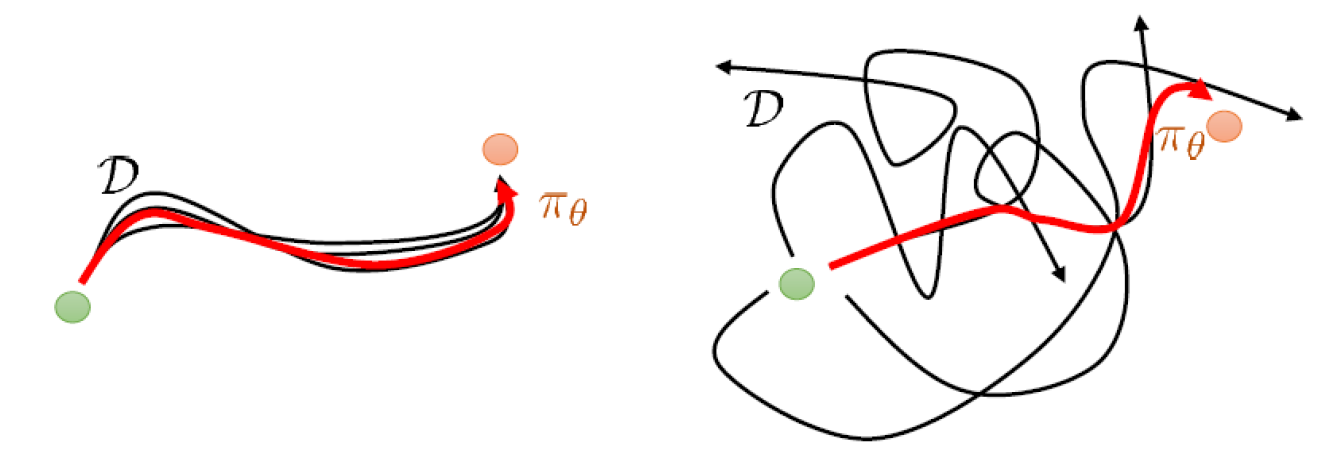

Проблема: неправильная оценка Q-функции из-за сдвига между распределениями $\pi_\beta$ и $\pi_\theta$.

Решения:
1. Ввести явные ограничения на данные при моделировании $\pi_\beta$
2. Ввести неявные ограничения на Q-функцию

## Неявное Q-обучение (IQL)

1. Идея: ограничем стратегию $\pi_{new}(a | s) = \arg \max_\pi \mathbb{E}_{a \sim \pi(a | s)} [Q(a, s)], D_{KL}(\pi || \pi_\beta) < \epsilon. $
2. Стратегия эксперта $\pi_\beta$ не известна.
3. Функция преимущества $A(s, a) = Q(s, a) - V(s)$ позволяет оценить насколько хорошо действие $a$.
4. Стратегия агента $\pi_\theta$ (BC + перевзвешивание с помощью A):
$$\theta ← \arg \max_\theta \mathbb{E}_{s, a \sim D}[\log \pi_\theta (a|s) \exp(A(s, a))]$$.


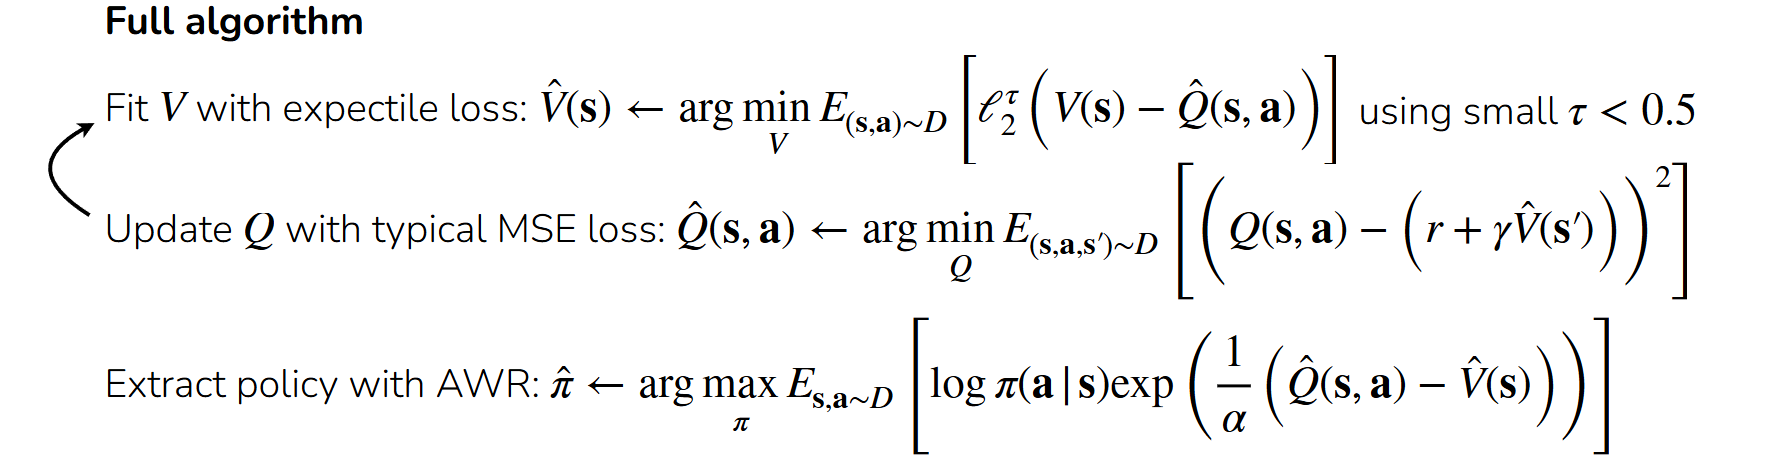

Ассимитричная функция потерь для V
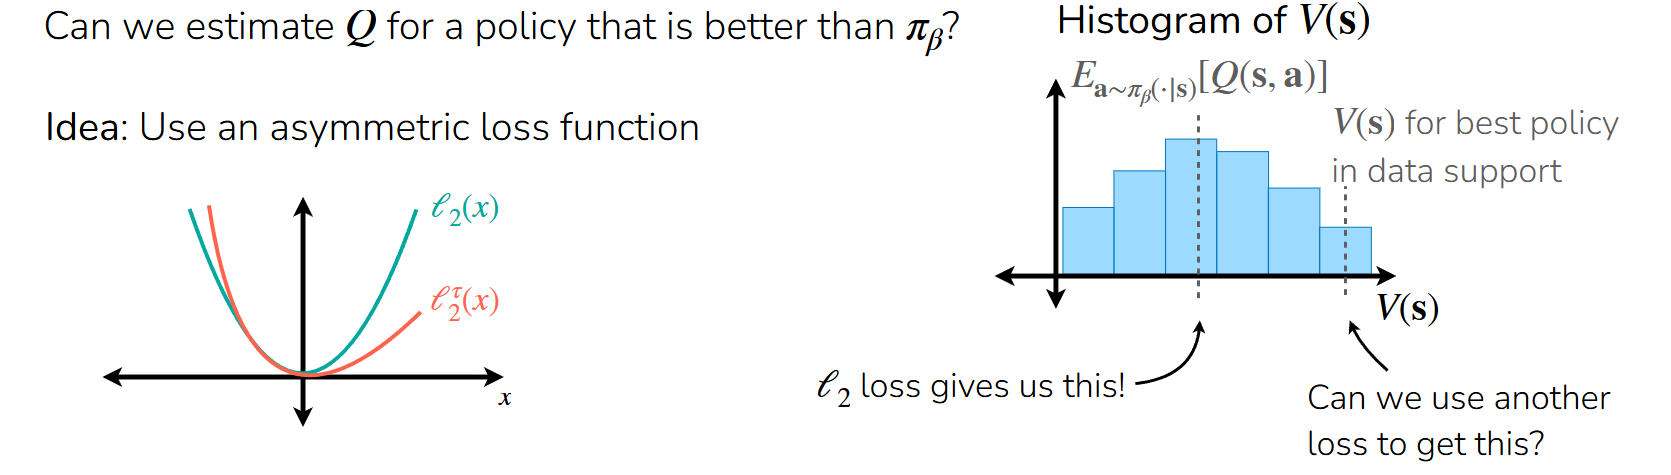

In [ ]:

@dataclass
class ConfigIQL(ConfigExp):
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 0.005
    """target smoothing coefficient (default: 0.005)"""
    batch_size: int = 1024
    """the batch size of sample from the reply memory"""
    policy_lr: float = 3e-4
    """the learning rate of the policy network optimizer"""
    q_lr: float = 3e-4
    """the learning rate of the Q network network optimizer"""
    policy_frequency: int = 1
    """the frequency of training policy (delayed)"""
    target_network_frequency: int = 1  # Denis Yarats' implementation delays this by 2.
    """the frequency of updates for the target nerworks"""
    alpha: float = 0
    """Entropy regularization coefficient."""
    autotune: bool = False
    """automatic tuning of the entropy coefficient"""
    beta: float = 3.0  # Inverse temperature. Small beta -> BC, big beta -> maximizing Q
    iql_tau: float = 0.7  # Coefficient for asymmetric loss
    vf_lr: float = 3e-4  # V function learning rate
    data_path: str = "notebook/data_umaze_d.hdf5"


(6 баллов)

In [ ]:
def asymmetric_l2_loss(adv: torch.Tensor, tau: float) -> torch.Tensor:
    return torch.mean(torch.abs(tau - (adv < 0).float()) * adv**2)


class IQLAgent(SACAgent):
    def init_actor_critic(self, observation_space_shape, action_space):
        super().init_actor_critic(observation_space_shape, action_space)
        self.vf = ValueFunction(observation_space_shape[0]).to(self.device)
        self.v_optimizer = optim.Adam(self.vf.parameters(), lr=self.cfg.vf_lr)
        self.actor_lr_schedule = CosineAnnealingLR(
            self.actor_optimizer, self.cfg.total_timesteps
        )

    def update_v(self, data):
        observations = data[0]
        actions = data[1]

        # Update value function
        with torch.no_grad():
            qf1_target = self.qf1_target(observations, actions)
            qf2_target = self.qf2_target(observations, actions)
            target_q = torch.min(qf1_target, qf2_target)

        # TODO: вычислить adv = Q - V
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################

        v_loss = asymmetric_l2_loss(adv, self.cfg.iql_tau)
        metrics = {"value_loss": v_loss.item()}

        self.v_optimizer.zero_grad()
        v_loss.backward()
        self.v_optimizer.step()
        return adv, metrics

    def compute_critic_loss(self, next_v, data) -> Tuple[torch.Tensor, dict, dict]:
        observations, actions, rewards, next_observations, dones = data
        rewards = rewards.view(-1)
        dones = dones.float().view(-1)

        # TODO: для s', a' вычислить Q(s', a'). targets = ...
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################

        qf1_a_values = self.qf1(observations, actions).view(-1)
        qf2_a_values = self.qf2(observations, actions).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, targets)
        qf2_loss = F.mse_loss(qf2_a_values, targets)
        qf_loss = qf1_loss + qf2_loss

        metrics = {
            "losses/qf1_values": qf1_a_values.mean().item(),
            "losses/qf2_values": qf2_a_values.mean().item(),
            "losses/qf1_loss": qf1_loss.item(),
            "losses/qf2_loss": qf2_loss.item(),
            "losses/qf_loss": qf_loss.item() / 2.0,
        }
        return qf_loss, metrics

    def actor_loss(self, adv, pi, log_pi, data):
        actions = data[1]

        if isinstance(pi, torch.distributions.Distribution):
            bc_losses = -pi.log_prob(actions).sum(-1, keepdim=False)
        elif torch.is_tensor(pi):
            if pi.shape != actions.shape:
                raise RuntimeError("Actions shape missmatch")
            bc_losses = torch.sum((pi - actions) ** 2, dim=1)
        else:
            raise NotImplementedError

        # TODO: вычислить loss для актора, используя bc_losses и adv
        #     actor_loss = mean(exp(beta * adv) * bc_losses)
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        return actor_loss

    def update_critic(
        self,
        next_v,
        data,
    ) -> dict:
        qf_loss, metrics = self.compute_critic_loss(next_v, data)

        # optimize the model
        self.q_optimizer.zero_grad()
        qf_loss.backward()
        self.q_optimizer.step()

        return metrics

    def update_actor(self, adv, data):
        observations = data[0]

        pi, log_pi, _ = self.actor.get_action(observations)

        actor_loss = self.actor_loss(adv, pi, log_pi, data)

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.actor_lr_schedule.step()

        metrics = {"losses/actor_loss": actor_loss.item()}

        return metrics

    def update(
        self,
        data,
        global_step,
    ) -> dict:
        # For IQL
        next_obs = data[3]
        with torch.no_grad():
            next_v = self.vf(next_obs)

        adv, metrics = self.update_v(data)

        # update critic
        critic_metrics = self.update_critic(next_v, data)
        metrics.update(critic_metrics)

        # update actor
        if global_step % self.cfg.policy_frequency == 0:
            for _ in range(self.cfg.policy_frequency):
                actor_metrics = self.update_actor(adv, data)
            metrics.update(actor_metrics)

        # update the target networks
        if global_step % self.cfg.target_network_frequency == 0:
            self.update_target_critic()
        return metrics

    def state_dict(self) -> Dict[str, Any]:
        return {
            "actor": self.actor.state_dict(),
            "vf": self.vf.state_dict(),
            "qf1": self.qf1.state_dict(),
            "qf2": self.qf2.state_dict(),
            "qf1_target": self.qf1_target.state_dict(),
            "qf2_target": self.qf2_target.state_dict(),
            "q_optimizer": self.q_optimizer.state_dict(),
            "actor_optim": self.actor_optimizer.state_dict(),
            "v_optimizer": self.v_optimizer.state_dict(),
            "actor_lr_schedule": self.actor_lr_schedule.state_dict(),
        }

    def load_state_dict(self, state_dict: Dict[str, Any]):
        self.actor.load_state_dict(state_dict=state_dict["actor"])
        self.qf1.load_state_dict(state_dict=state_dict["qf1"])
        self.qf2.load_state_dict(state_dict=state_dict["qf2"])
        self.qf1_target.load_state_dict(state_dict=state_dict["qf1_target"])
        self.qf2_target.load_state_dict(state_dict=state_dict["qf2_target"])

        self.q_optimizer.load_state_dict(state_dict=state_dict["q_optimizer"])
        self.actor_optimizer.load_state_dict(state_dict=state_dict["actor_optim"])

        self.v_optimizer.load_state_dict(state_dict=state_dict["v_optimizer"])
        self.vf.load_state_dict(state_dict=state_dict["vf"])
        self.actor_lr_schedule.load_state_dict(state_dict["actor_lr_schedule"])


### Хороший датасет

In [ ]:
config = ConfigIQL(data_path="/content/data_umaze_dense.hdf5",
                   total_timesteps=1000, eval_freq= int(1e2))
agent_IQL = train(config, IQLAgent, ReplayBuffer, train_offline, make_env)

In [ ]:
eval = Evaluate(make_env, EnvConfig())
eval.eval_tr(agent_IQL)
Image(filename='output.png')

### Плохой датасет

In [ ]:
config = ConfigIQL(data_path="/content/data_umaze_bad.hdf5",
                   total_timesteps=1000, eval_freq= int(1e2))
agent_IQL = train(config, IQLAgent, ReplayBuffer, train_offline, make_env)

In [ ]:
eval = Evaluate(make_env, EnvConfig())
eval.eval_tr(agent_IQL)
Image(filename='output.png')